## Gerando imagens panorâmicas (Pano Stitch)
***

Quando você tem um iphone você tem a opção de tirar uma foto panorâmica

Funciona da seguinte maneira, você aponta a camerâ ele começa a tirar várias fotos enquanto você movimenta a câmera e no final o algoritmo mescla essas fotos em uma única foto.

OBS: É necessário compilar o openCV com os módulos extras.

![image](https://user-images.githubusercontent.com/14116020/72210295-d8c95280-3497-11ea-9187-30c98198110e.png)

***

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2


def show(img, title=""):
    """
    Redimensionar a imagem e mostrar no codigo.
    """

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.rcParams['figure.figsize'] = (50, 50)
    plt.title(title, fontdict={"fontsize": 100})
    plt.imshow(img)
    plt.axis("off")
    plt.show()

In [2]:
def warpImages(img1, img2, H):
    """
    Faz a junção do resultado final das imagens usando a matriz H
    """

    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0,0], [0,rows1], [cols1,rows1], [cols1,0]]).reshape(-1,1,2)
    temp_points = np.float32([[0,0], [0,rows2], [cols2,rows2], [cols2,0]]).reshape(-1,1,2)
    list_of_points_2 = cv2.perspectiveTransform(temp_points, H)
    list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)
    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0,0,1]]) 

    output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max-x_min, y_max-y_min))
    output_img[translation_dist[1]:rows1+translation_dist[1], translation_dist[0]:cols1+translation_dist[0]] = img1
    
    return output_img

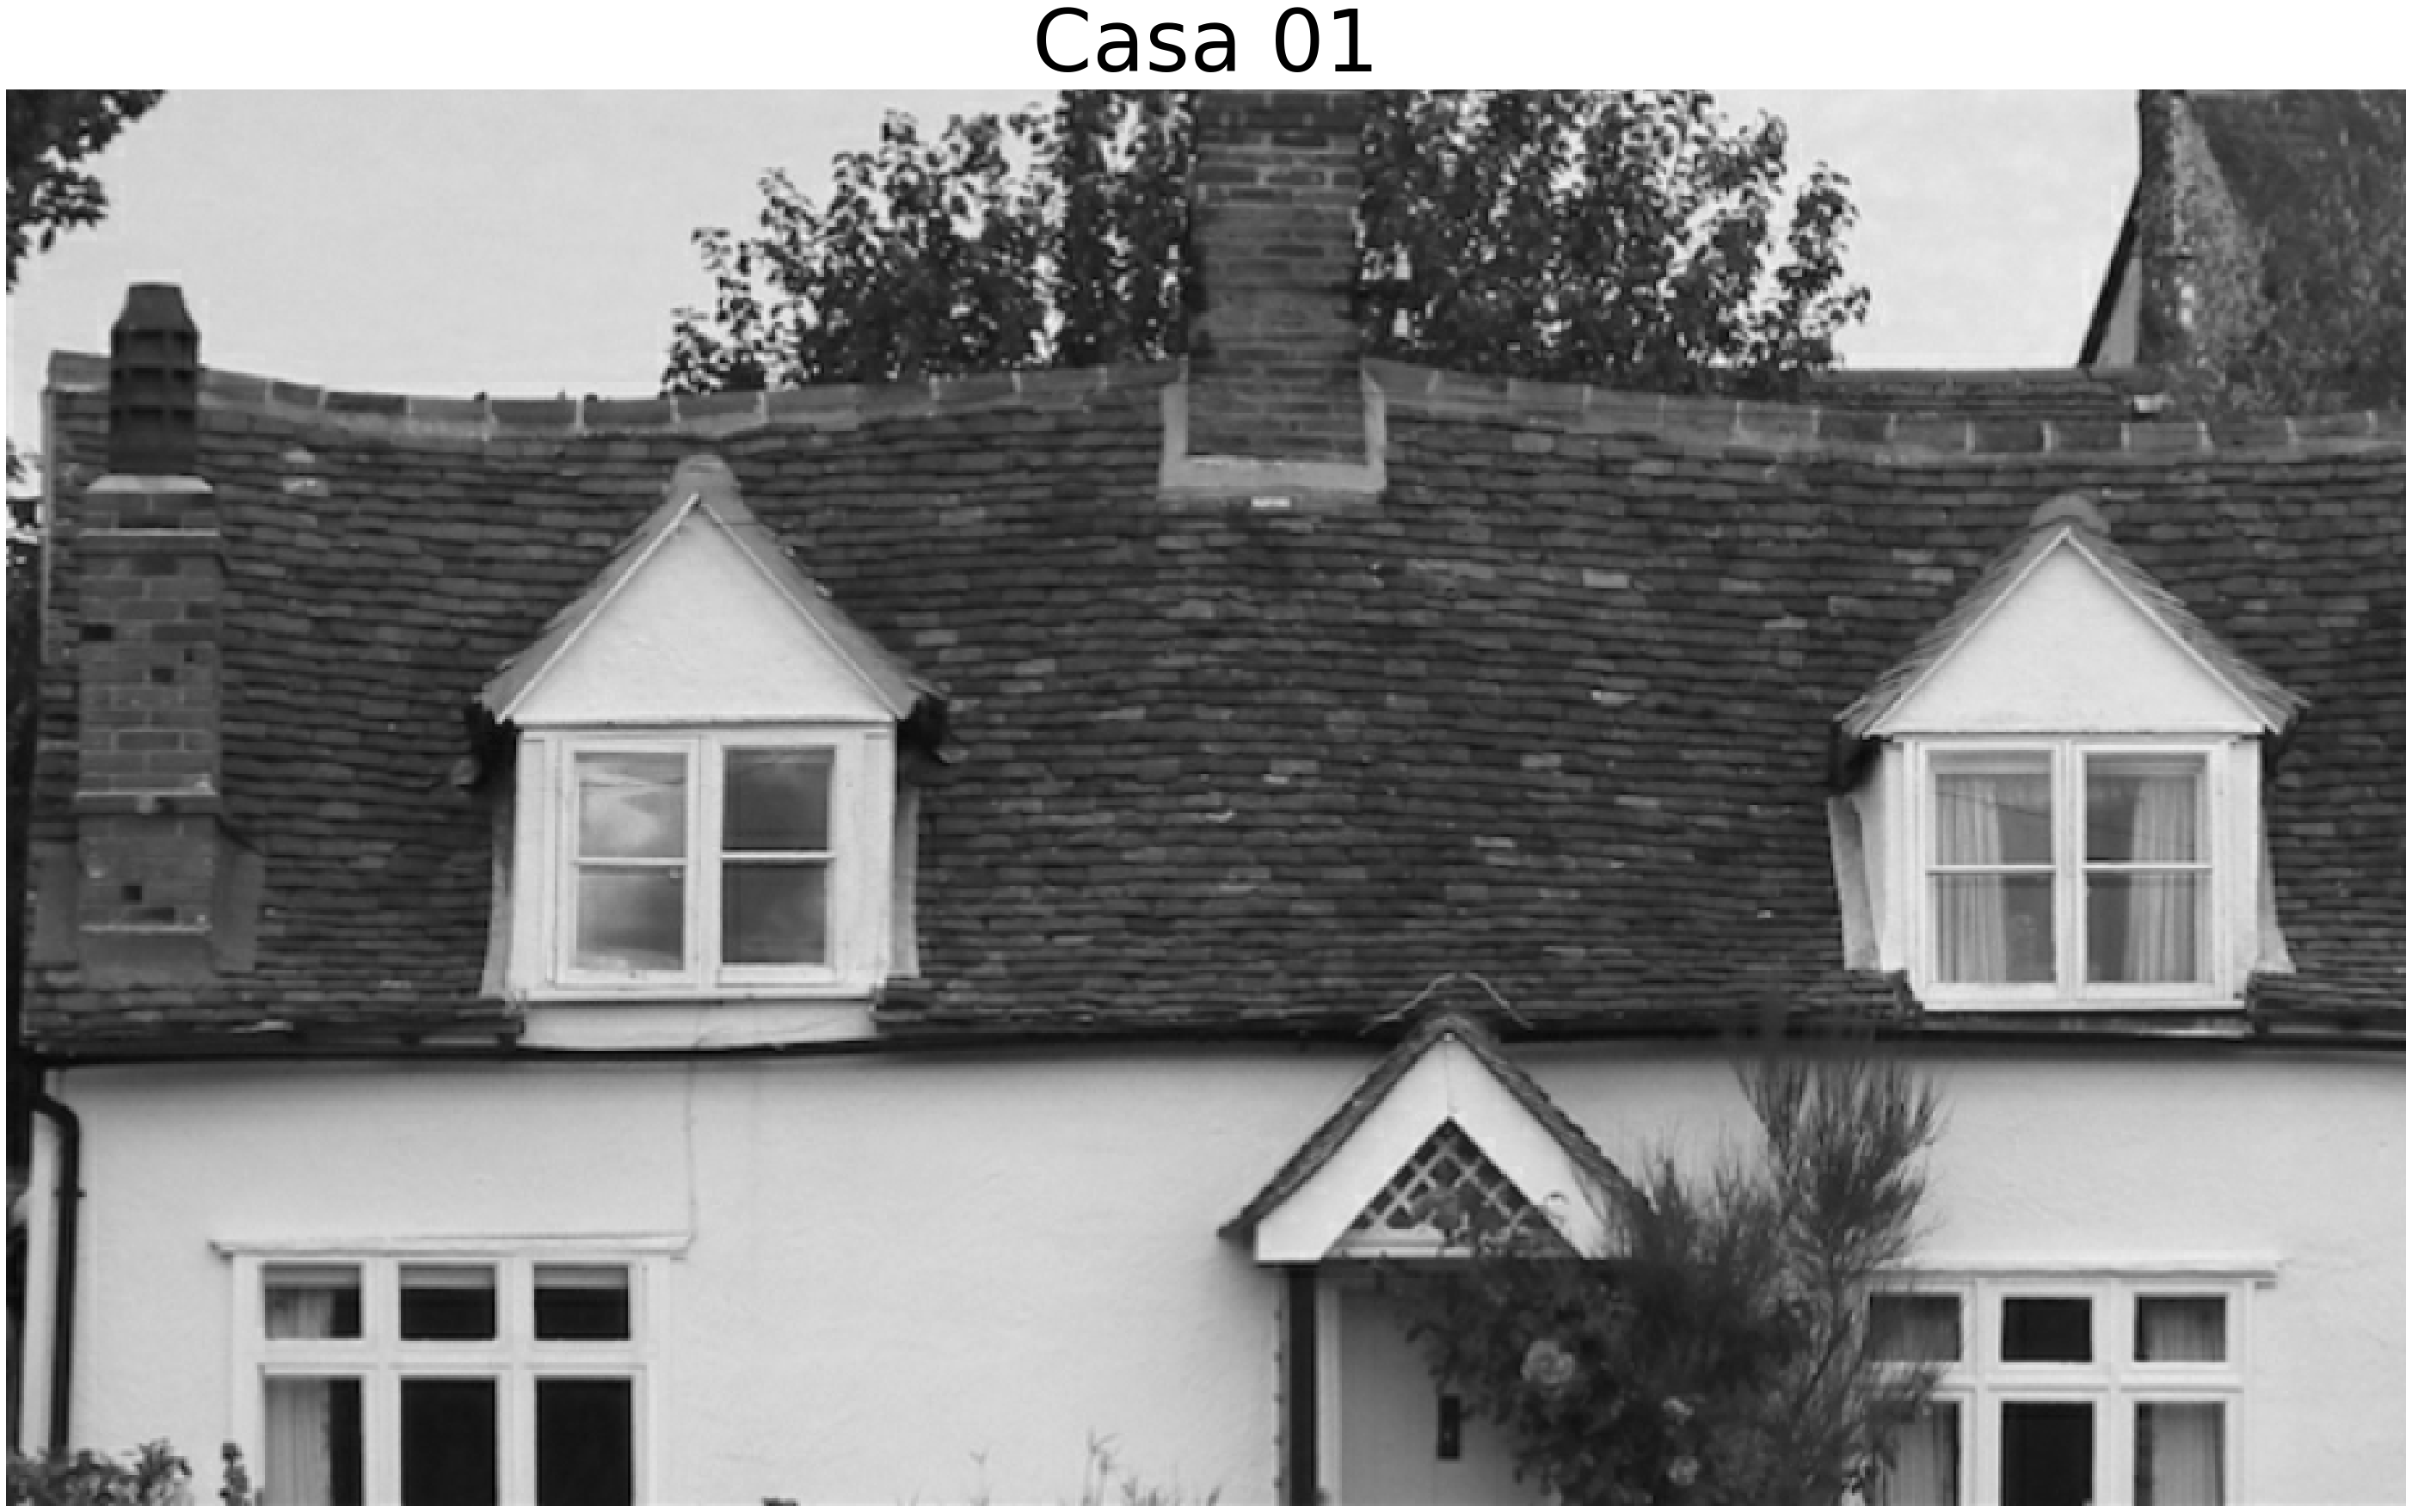

In [3]:
img1 = cv2.imread('imagens/casa1.png', 0) # query Image
show(img1, "Casa 01")

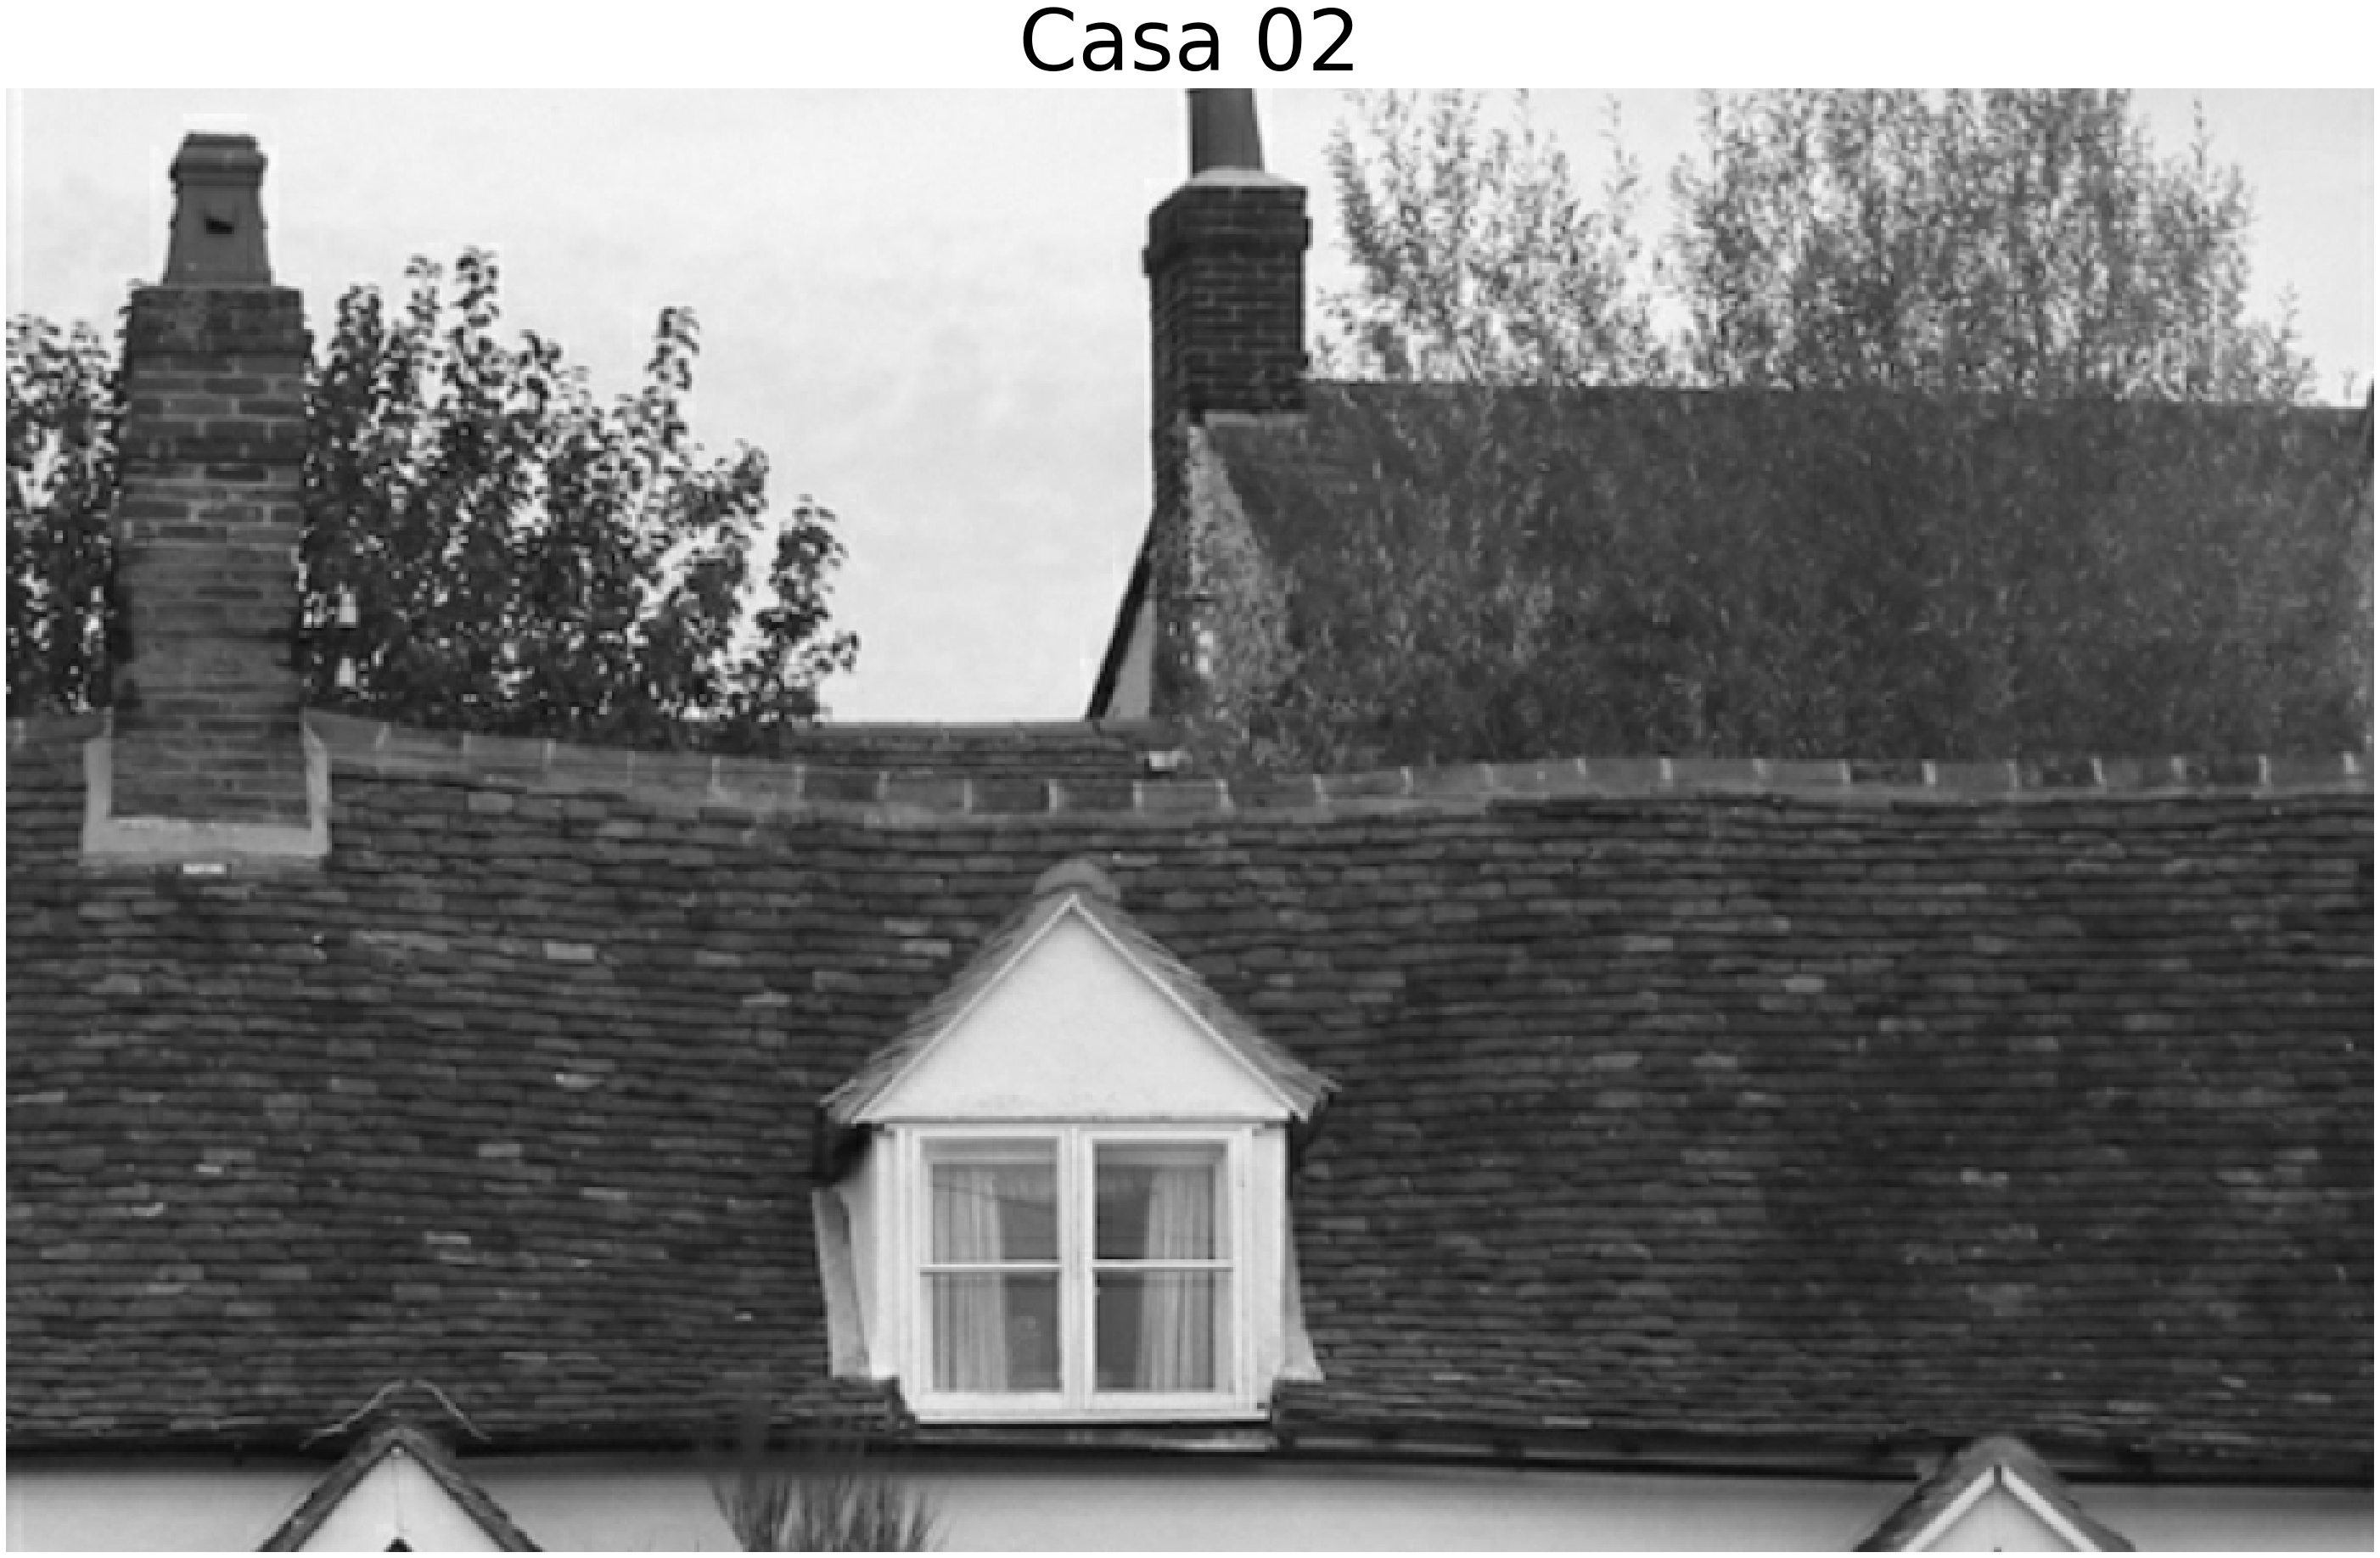

In [4]:
img2 = cv2.imread('imagens/casa2.png', 0) # train Image
show(img2, "Casa 02")

In [ ]:
# SIFT detector (detector de keypoints ou pontos de interesse)
sift = cv2.xfeatures2d.SIFT_create()

In [ ]:
# Extrai keypoints e descriptors
keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

In [ ]:
# Inicializa os parâmetros para o Flann based matcher (junção dos descritores de cada uma das imagens)
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

In [ ]:
"""
Inicializa o objeto Matcher baseado em Flann

O matcher baseado em Flann é mais rápido do que a combinação Brute Force porque não
compara cada ponto com cada ponto na outra lista. 

Só considera a vizinhança do ponto atual para obter o ponto-chave correspondente, tornando-o mais eficiente. 

Uma vez que obtemos uma lista de pontos-chave correspondentes, usamos o teste de
proporção da Lowe para manter apenas as correspondências fortes. 

David Lowe propôs este teste de razão para aumentar a robustez do SIFT.

Basicamente esse algoritmo que vai costurar as imagens.
"""
flann = cv2.FlannBasedMatcher(index_params, search_params)

In [ ]:
"""
Computa os matches

Basicamente, quando combinamos os pontos-chave, rejeitamos as correspondências em que a
proporção das distâncias para o vizinho mais próximo e o segundo vizinho mais próximo é
maior que um determinado limite. Isso nos ajuda a descartar os pontos que não são distintos o suficiente. 

Então, usamos esse conceito aqui para manter apenas as boas correspondências e
descartar o resto. Se não tivermos correspondências suficientes, não avançaremos. 

No nosso caso, o valor padrão é 10. Você pode brincar com este parâmetro de
entrada para ver como isso afeta a saída.

É a junção dos descritores baseados no algoritmo KNN
"""
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

In [ ]:
# Armazena todas as boas combinações de acordo com o teste de proporção Lowe
good_matches = []
for m1,m2 in matches:
    if m1.distance < 0.7*m2.distance:
        good_matches.append(m1)

In [ ]:
if len(good_matches) > min_match_count:
    src_pts = np.float32([ keypoints1[good_match.queryIdx].pt for good_match in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ keypoints2[good_match.trainIdx].pt for good_match in good_matches ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    result = warpImages(img2, img1, M)
    show(result, "Output")
else:
    print ("Não temos número suficiente de correspondências (matches) entre as duas imagens.")
    print ("Encontrado apenas %d correspondências. Precisamos de pelo menos %d correspondências." % (len(good_matches), min_match_count))

As duas imagens pretas é pq não houve similaridade entre as imagens de recurso, por isso que nos iphones eles deixam um tipo de regua horizontal para que a imagem panoramica não tenha essas partes pretas.

![img](https://user-images.githubusercontent.com/14116020/72210465-c6044d00-349a-11ea-8822-cfce4a522bd4.png)